In [1]:
%matplotlib inline
from matplotlib import style
from matplotlib import figure
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///./Resources/hawaii.sqlite")


In [5]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine,reflect=True)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [8]:
# Create the inspector and connect it to the engine
inspector = inspect(engine)

In [9]:
# Using the inspector to print the column names within the 'measurement' table and its types
measurement_columns = inspector.get_columns('measurement')

for each in measurement_columns:
    print(each['name'], each['type'])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [10]:
# Using the inspector to print the column names within the 'station' table and its types
station_columns = inspector.get_columns('station')
for each in station_columns:
    print(each['name'], each['type'])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [11]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [12]:
# Find the most recent date in the data set.
recent_date = session.query(measurement.date).order_by(measurement.date.desc()).first()
print(recent_date)

('2017-08-23',)


In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database.

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017,8,23) - dt.timedelta(days=365)
print(f"Query Date: {query_date}")

# Perform a query to retrieve the data and precipitation scores
prcp_scores = session.query(measurement.date, measurement.prcp).filter(measurement.date >= query_date).all()

Query Date: 2016-08-23


In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
prcp_df = pd.DataFrame(prcp_scores, columns = ['date', 'prcp'])
prcp_df.set_index("date", inplace=True)

# Rename the column
prcp_df = prcp_df.rename(columns={'prcp':'precipitation'})

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(['date']).dropna()
prcp_df.head()

,precipitation
date,
2016-08-23,0.00
2016-08-23,1.79
2016-08-23,0.05
2016-08-23,0.15
2016-08-23,0.70


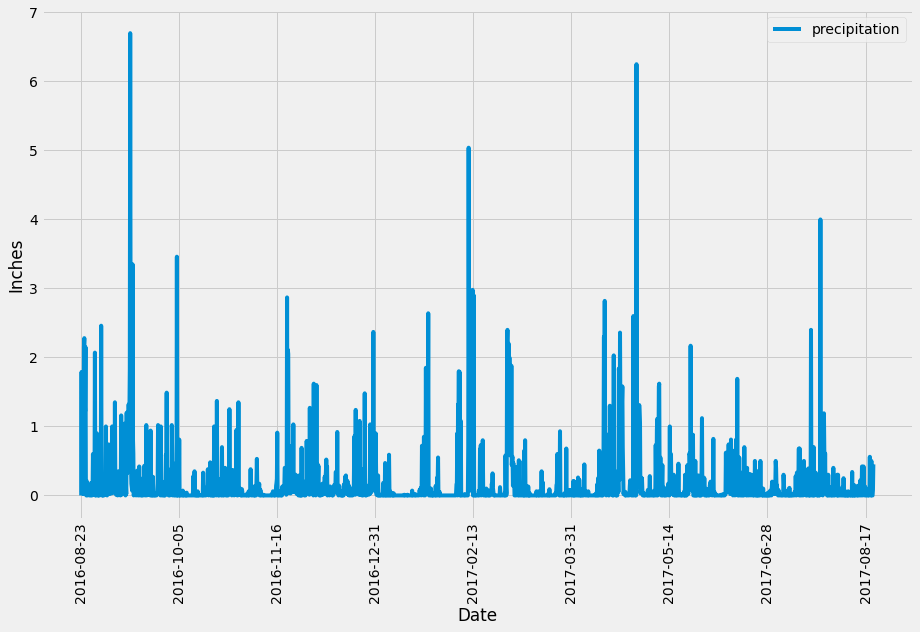

In [54]:
# Use Pandas Plotting with Matplotlib to plot the data
ax = prcp_df.plot(figsize=(13,9), rot=90)
ax.set_xlabel('Date')
ax.set_ylabel('Inches')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig("./Images/Precipation.png")
plt.show()

In [52]:
# Use Pandas to calcualte the summary statistics for the precipitation data
prcp_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number stations in the dataset
station_count = session.query(station.id).count()
print(f'Total Number of stations: {station_count}')

Total Number of stations: 9


In [18]:
# Design a query to find the most active stations (i.e. what stations have the most rows?)
# List the stations and the counts in descending order.
active_stations = session.query(measurement.station,func.count(measurement.station)).group_by(measurement.station).order_by((func.count(measurement.station)).desc()).all()
for each in active_stations:
    print(each)

('USC00519281', 2772)
('USC00519397', 2724)
('USC00513117', 2709)
('USC00519523', 2669)
('USC00516128', 2612)
('USC00514830', 2202)
('USC00511918', 1979)
('USC00517948', 1372)
('USC00518838', 511)


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = active_stations[0][0]
print(f'Most active station id: {most_active_station}')

session.query(func.min(measurement.tobs), 
              func.max(measurement.tobs), 
              func.avg(measurement.tobs)).filter(measurement.station == most_active_station).all()

Most active station id: USC00519281


[(54.0, 85.0, 71.66378066378067)]

In [39]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_obs_data = session.query(measurement.date, measurement.tobs).\
                            filter(measurement.date >= query_date).\
                            filter(measurement.station == most_active_station).all()



# Save the query results as a Pandas DataFrame and set the index to the date column
temp_data_df = pd.DataFrame(temp_obs_data, columns = ['date', 'tobs'])
temp_data_df

,date,tobs
0,2016-08-23,77.0
1,2016-08-24,77.0
2,2016-08-25,80.0
3,2016-08-26,80.0
4,2016-08-27,75.0
...,...,...
347,2017-08-14,77.0
348,2017-08-15,77.0
349,2017-08-16,76.0
350,2017-08-17,76.0


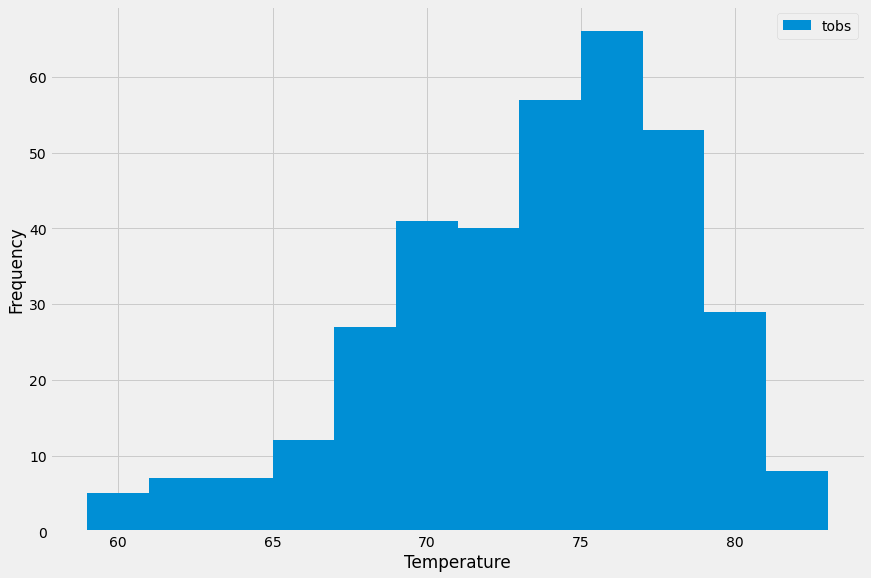

In [48]:
# Plot the results as a histogram
ax = temp_data_df.plot.hist(bins=12, figsize =(13,9))
ax.set_xlabel("Temperature")
plt.savefig("./Images/Temperatures.png")
plt.show()

# Close session

In [55]:
# Close Session
session.close()

('USC00519397', 'WAIKIKI 717.2, HI US')
('USC00513117', 'KANEOHE 838.1, HI US')
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US')
('USC00517948', 'PEARL CITY, HI US')
('USC00518838', 'UPPER WAHIAWA 874.3, HI US')
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US')
('USC00519281', 'WAIHEE 837.5, HI US')
('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US')
('USC00516128', 'MANOA LYON ARBO 785.2, HI US')


In [72]:
last_year_date = (dt.datetime.strptime(recent_date[0], '%Y-%m-%d') \
                  - dt.timedelta(days=365)).strftime('%Y-%m-%d')

print(last_year_date)

2016-08-23
